In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Pull dem csv in, created a partial csv, just in case I needed to test

full_df = pd.read_csv('data/full_df.csv', error_bad_lines = False, warn_bad_lines = False)
part_df = pd.read_csv('data/full_df.csv', error_bad_lines = False, warn_bad_lines = False, nrows = 5000)

In [3]:
#All of the below was for exploration

#print(part_df)

In [4]:
#full_df['PARTITION'].value_counts()

In [5]:
#part_df['STATE'].value_counts()

In [6]:
#full_df['EXITCODE'].value_counts()

In [7]:
#full_df['ACCOUNT'].value_counts()

In [8]:
#full_df['USER'].value_counts()

In [9]:
#full_df.loc[full_df['USER']=='cmslocal']

In [10]:
#full_df['NODELIST'].value_counts()

In [11]:
#Created work_df of all jobs that ended in under an hour

work_df = full_df.query('TOTAL_SEC_USED < 3601')

In [12]:
#Exploration code

#work_df.head(5)

In [13]:
#Exploration code to make sure, longest job is 1,205 seconds 

work_df['TOTAL_SEC_USED'].value_counts(ascending=True)

26         17
16         21
19         22
24         23
28         25
        ...  
1203    11595
1207    11962
1206    14623
1204    17480
1205    17992
Name: TOTAL_SEC_USED, Length: 3601, dtype: int64

In [14]:
#Proper query call to create a df of cms user jobs under the two partition tags

cms_df = work_df.query('(USER == "cmspilot" or USER == "cmslocal") and (PARTITION in ["production","nogpfs"])')

In [15]:
#Proper query call to create a df of non-cms user jobs under the two partition tags

ncms_df = work_df.query('USER != "cmspilot" and USER != "cmslocal" and (PARTITION == "production" or PARTITION == "nogpfs")')

In [16]:
#Exploration and test code

cms_df['PARTITION'].value_counts()
#cms_df['USER'].value_counts()

nogpfs        214008
production    207847
Name: PARTITION, dtype: int64

In [17]:
#Exploration and test code

ncms_df['PARTITION'].value_counts()
#ncms_df['USER'].value_counts()

production    1329678
nogpfs          16255
Name: PARTITION, dtype: int64

In [18]:
#More exploration code

#cms_df.info()
#ncms_df.info()

In [19]:
#Code for checking work, ensuring operations were successful

#cms_df['NODELIST'].value_counts().head(25)
#cms_df['NODELIST'].value_counts(normalize=True)
#cms_df['PARTITION'].value_counts()


In [20]:
#Code for checking work, ensuring operations were successful

#ncms_df['NODELIST'].value_counts().head(25)
#ncms_df['NODELIST'].value_counts(normalize=True)
#ncms_df['PARTITION'].value_counts()

In [21]:
cms_df['NODELIST'].value_counts().sum()

421855

In [22]:
ncms_df['NODELIST'].value_counts().sum()

1345933

In [23]:
#Test code

#ncms_df.groupby('USER')['NODELIST'].value_counts().apply(lambda u: u>3000).sum()

In [24]:
#Aggregated the data frame information by node, cms and non-cms

cms_nodecount = pd.DataFrame(data=cms_df['NODELIST'].value_counts())
ncms_nodecount = pd.DataFrame(data=ncms_df['NODELIST'].value_counts())

#Reset index because because

cms_nodecount = cms_nodecount.reset_index()
ncms_nodecount = ncms_nodecount.reset_index()

#Renamed column names so I can join/merge them later on

cms_nodecount.rename(columns={'index':'NODE', 'NODELIST':'NODECOUNT'}, inplace=True)
ncms_nodecount.rename(columns={'index':'NODE', 'NODELIST':'NODECOUNT'}, inplace=True)

#Check work

print(cms_nodecount)
print(ncms_nodecount)

       NODE  NODECOUNT
0    ng1078       5626
1    ng1112       5526
2    ng1040       5249
3    ng1027       5166
4    ng1003       5135
..      ...        ...
793   ng225          1
794  cn1415          1
795  cn1417          1
796   ng217          1
797  cn1410          1

[798 rows x 2 columns]
               NODE  NODECOUNT
0             cn304       7114
1             cn430       6140
2             cn425       6093
3            cn1438       6066
4             cn416       5996
...             ...        ...
1125        cn[1210          1
1126  cn[1267-1268]          1
1127    cn[473-474]          1
1128  cn[1514-1515]          1
1129  cn[1320-1321]          1

[1130 rows x 2 columns]


In [25]:
#Performed an outter merge of all failed nodes, both cms and non-cms

nodes_df = cms_nodecount.merge(ncms_nodecount, on='NODE', how='outer', suffixes=('_CMS','_NCMS'))

#Filled in NaN as 0 for consistency and mathematical operations

nodes_df.fillna(0, inplace=True)

#Created a column of total failed nodes, cms and non-cms

nodes_df['NODECOUNT_TOT'] = nodes_df['NODECOUNT_CMS'] + nodes_df['NODECOUNT_NCMS']
print(nodes_df)

               NODE  NODECOUNT_CMS  NODECOUNT_NCMS  NODECOUNT_TOT
0            ng1078         5626.0           198.0         5824.0
1            ng1112         5526.0           374.0         5900.0
2            ng1040         5249.0           147.0         5396.0
3            ng1027         5166.0           132.0         5298.0
4            ng1003         5135.0           204.0         5339.0
...             ...            ...             ...            ...
1137        cn[1210            0.0             1.0            1.0
1138  cn[1267-1268]            0.0             1.0            1.0
1139    cn[473-474]            0.0             1.0            1.0
1140  cn[1514-1515]            0.0             1.0            1.0
1141  cn[1320-1321]            0.0             1.0            1.0

[1142 rows x 4 columns]


In [26]:
#Created Columns of the nodecount as a percentage of failed nodes

nodes_df['PERC_CMS'] = nodes_df['NODECOUNT_CMS']/nodes_df['NODECOUNT_CMS'].sum()
nodes_df['PERC_NCMS'] = nodes_df['NODECOUNT_NCMS']/nodes_df['NODECOUNT_NCMS'].sum()
nodes_df['PERC_TOT'] = nodes_df['NODECOUNT_TOT']/nodes_df['NODECOUNT_TOT'].sum()

#Created a column to tag whether or not a node was ever called by a CMS user for visualization later

nodes_df['CMS_TAG'] = nodes_df['NODECOUNT_CMS']>0
print(nodes_df)

               NODE  NODECOUNT_CMS  NODECOUNT_NCMS  NODECOUNT_TOT  PERC_CMS  \
0            ng1078         5626.0           198.0         5824.0  0.013336   
1            ng1112         5526.0           374.0         5900.0  0.013099   
2            ng1040         5249.0           147.0         5396.0  0.012443   
3            ng1027         5166.0           132.0         5298.0  0.012246   
4            ng1003         5135.0           204.0         5339.0  0.012172   
...             ...            ...             ...            ...       ...   
1137        cn[1210            0.0             1.0            1.0  0.000000   
1138  cn[1267-1268]            0.0             1.0            1.0  0.000000   
1139    cn[473-474]            0.0             1.0            1.0  0.000000   
1140  cn[1514-1515]            0.0             1.0            1.0  0.000000   
1141  cn[1320-1321]            0.0             1.0            1.0  0.000000   

         PERC_NCMS      PERC_TOT  CMS_TAG  
0     1

In [27]:
#For some reason, running the line below eliminates all False tagged rows, but 
#calling the False designation does not??????

#nodes_df.loc[nodes_df['CMS_TAG'] == True, 'CMS_TAG'] = 'Yes'

#This code properly flags the CMS tag since Seaborn did not like it

nodes_df.loc[nodes_df['CMS_TAG'] == False, 'CMS_TAG'] = 'No'
nodes_df.loc[nodes_df['CMS_TAG'] != 'No', 'CMS_TAG'] = 'Yes'
print(nodes_df)

               NODE  NODECOUNT_CMS  NODECOUNT_NCMS  NODECOUNT_TOT  PERC_CMS  \
0            ng1078         5626.0           198.0         5824.0  0.013336   
1            ng1112         5526.0           374.0         5900.0  0.013099   
2            ng1040         5249.0           147.0         5396.0  0.012443   
3            ng1027         5166.0           132.0         5298.0  0.012246   
4            ng1003         5135.0           204.0         5339.0  0.012172   
...             ...            ...             ...            ...       ...   
1137        cn[1210            0.0             1.0            1.0  0.000000   
1138  cn[1267-1268]            0.0             1.0            1.0  0.000000   
1139    cn[473-474]            0.0             1.0            1.0  0.000000   
1140  cn[1514-1515]            0.0             1.0            1.0  0.000000   
1141  cn[1320-1321]            0.0             1.0            1.0  0.000000   

         PERC_NCMS      PERC_TOT CMS_TAG  
0     1.

In [28]:
nodes_df.query('PERC_NCMS > 0.0015 or NODECOUNT_CMS > 1000', inplace = True)

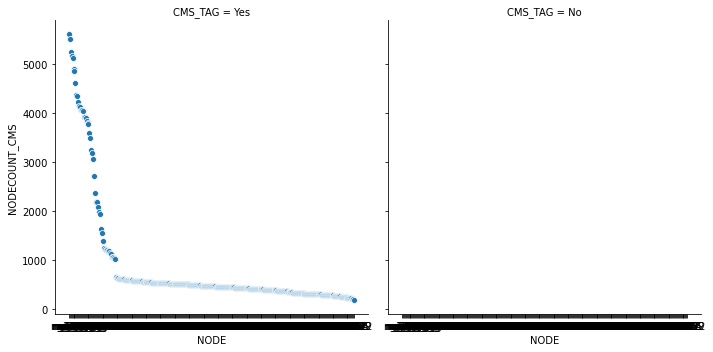

In [31]:
#sns.scatterplot(data = nodes_df, x='NODE', y='NODECOUNT_CMS', hue='CMS_TAG')

sns.relplot(x = 'NODE', y = 'NODECOUNT_CMS', data = nodes_df, 
            kind = 'scatter', col = 'CMS_TAG', col_order = ['Yes', 'No'])

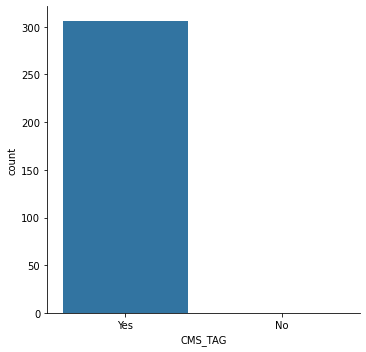

In [30]:
sns.catplot(x = 'CMS_TAG', data = nodes_df, 
            kind = 'count', order = ['Yes','No'])